# Classification

In this notebook we can see the application of several classification models to predict whether a team will make the playoffs in the following year. 

It takes data from years 1 to 9 for training the models, and data from year 10 for testing. Here's an overview of how the script works:

First, the dataset is loaded, and the data is split into training and testing sets. The training set consists of data from years 1 through 9, while the testing set consists of data from year 10. 

Then we selected the features (i.e., the input variables) by excluding the target variable (`PlayOffNextYear`), as well as team-specific identifiers like `tmID` and `year`. To ensure the data is properly scaled, the features are standardized using `StandardScaler`.

Then we define a range of classification models to evaluate, including Logistic Regression, K-Nearest Neighbors (KNN), Random Forest, Naive Bayes, Decision Tree, XGBoost, Gradient Boosting, and Support Vector Machine (SVM). For the XGBoost and Gradient Boosting models, we used SMOTE (Synthetic Minority Over-sampling Technique). 

Once the models are defined and the data is prepared, the following step was to train each model using the scaled training data. For the models that use SMOTE, the training was done on the balanced dataset. 

After training, we were able to guarantee to the models to make predictions and calculate several evaluation metrics for each model, including accuracy, precision, recall, and F1 score. These metrics help determine how well the models are performing.

Additionally, we used `ClassificationUtils` to generate visualizations such as confusion matrices and learning curves, which help in understanding how each model behaves and where it might be making mistakes. In this way we had a deeper insight into the models' performance, and it helped us to identify areas for improvement.

Finally, we collected all the results in a summary table, showing the performance of each model across all the metrics. In this way we made comparison between the models to see the best possible outcome.

In [43]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from classification_utils import ClassificationUtils
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

file_path = '../newData/Shifted_playoff.csv' 
df = pd.read_csv(file_path)

In [44]:

train_df = df[df['year'] < 10]
test_df = df[df['year'] == 11]

X_train = train_df.drop(columns=["PlayOffNextYear", "tmID", "year"])
y_train = train_df["PlayOffNextYear"]

X_test = test_df.drop(columns=["PlayOffNextYear", "tmID", "year"])
y_test = test_df["PlayOffNextYear"] 

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Training Logistic Regression...


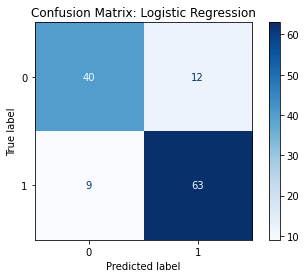

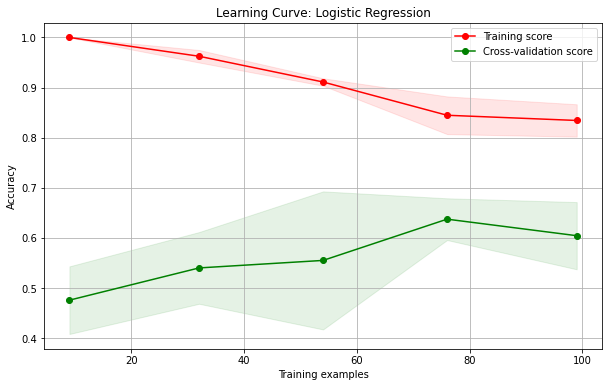

Training KNN...


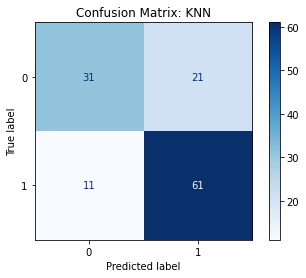

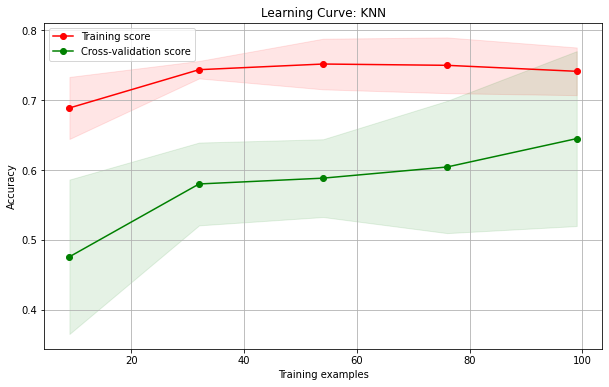

Training Random Forest...


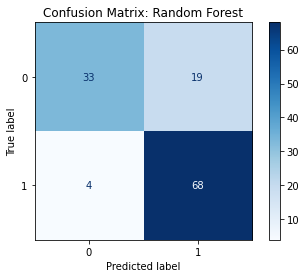

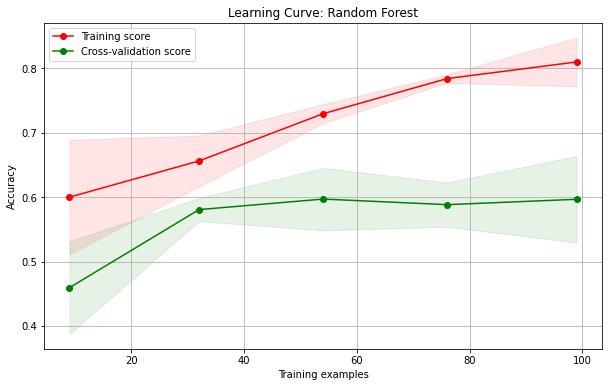

Training Naive Bayes...


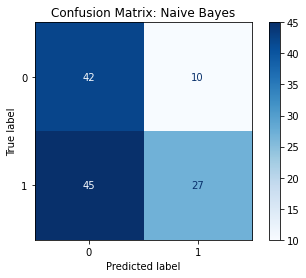

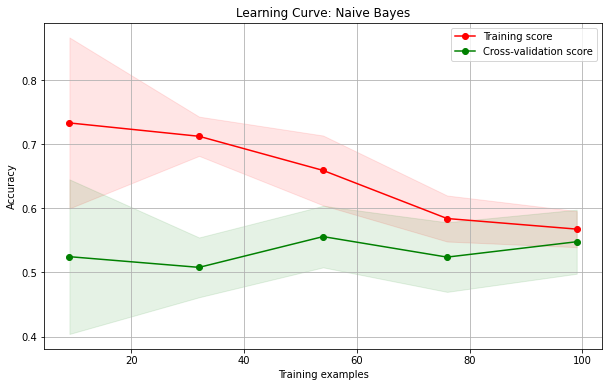

Training Decision Tree...


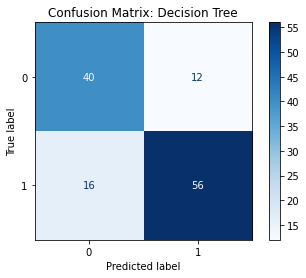

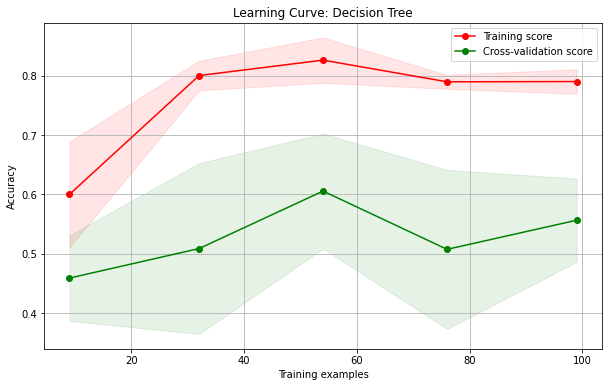

Training XGBoost with SMOTE-balanced dataset...


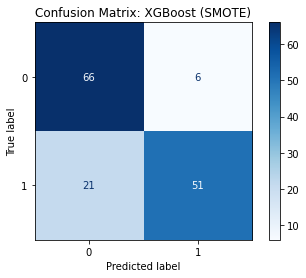

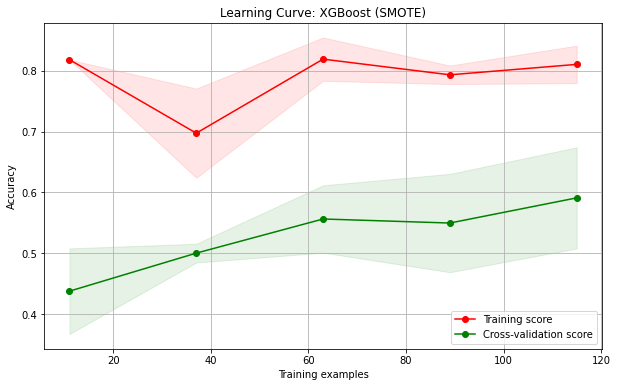

Training Gradient Boosting with SMOTE-balanced dataset...


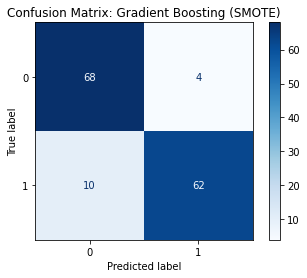

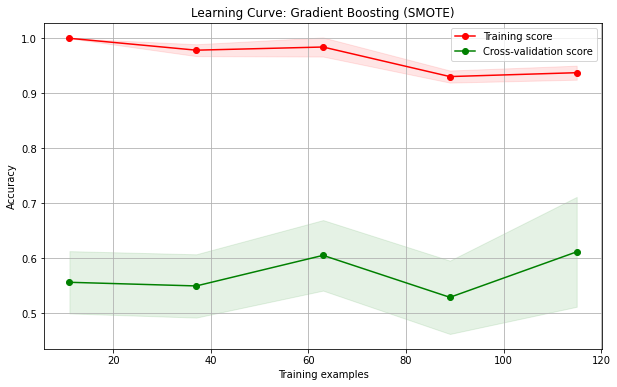

Training SVM...


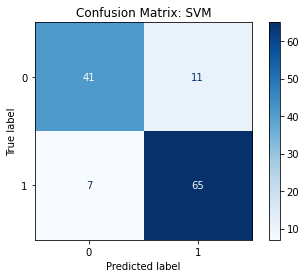

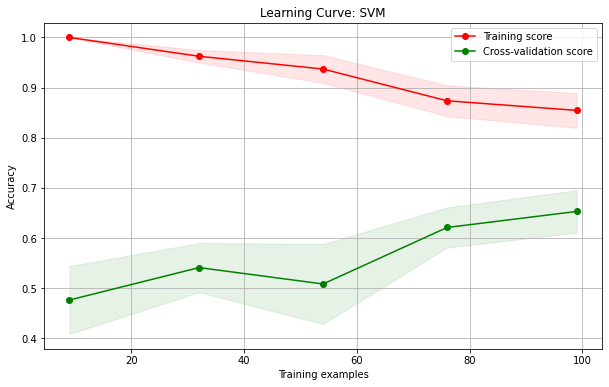

Model evaluation results:


,Accuracy,Precision,Recall,F1
Logistic Regression,0.830645,0.840000,0.875000,0.857143
KNN,0.741935,0.743902,0.847222,0.792208
Random Forest,0.814516,0.781609,0.944444,0.855346
Naive Bayes,0.556452,0.729730,0.375000,0.495413
Decision Tree,0.774194,0.823529,0.777778,0.800000
XGBoost (SMOTE),0.812500,0.894737,0.708333,0.790698
Gradient Boosting (SMOTE),0.902778,0.939394,0.861111,0.898551
SVM,0.854839,0.855263,0.902778,0.878378


In [45]:
models = {
    "Logistic Regression": LogisticRegression(),
    "KNN": KNeighborsClassifier(),
    "Random Forest": RandomForestClassifier(max_depth=5, min_samples_leaf=10, random_state=42),
    "Naive Bayes": GaussianNB(),
    "Decision Tree": DecisionTreeClassifier(max_depth=5, min_samples_leaf=10, random_state=42),
    "XGBoost": XGBClassifier(max_depth=2, n_estimators=50, learning_rate=0.05, reg_lambda=15, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(max_depth=2, n_estimators=50, learning_rate=0.05, random_state=42),
    "SVM": SVC(kernel="linear", probability=True)
}

smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

results = {}
for model_name, model in models.items():
    if model_name in ["XGBoost", "Gradient Boosting"]:
       
        print(f"Training {model_name} with SMOTE-balanced dataset...")
        model.fit(X_train_balanced, y_train_balanced)
        predictions = model.predict(X_train_balanced)
        accuracy = accuracy_score(y_train_balanced, predictions)
        precision = precision_score(y_train_balanced, predictions)
        recall = recall_score(y_train_balanced, predictions)
        f1 = f1_score(y_train_balanced, predictions)

        results[f"{model_name} (SMOTE)"] = {
            "Accuracy": accuracy,
            "Precision": precision,
            "Recall": recall,
            "F1": f1
        }

        ClassificationUtils.plot_confusion_matrix(
            y_train_balanced, predictions, model_name=f"{model_name} (SMOTE)"
        )
        ClassificationUtils.plot_learning_curve(
            estimator=model,
            X=X_train_balanced,
            y=y_train_balanced,
            title=f"Learning Curve: {model_name} (SMOTE)",
            cv=5
        )
    else:
       
        print(f"Training {model_name}...")
        model.fit(X_train_scaled, y_train)

        predictions = model.predict(X_train_scaled)

        accuracy = accuracy_score(y_train, predictions)
        precision = precision_score(y_train, predictions)
        recall = recall_score(y_train, predictions)
        f1 = f1_score(y_train, predictions)

        results[model_name] = {
            "Accuracy": accuracy,
            "Precision": precision,
            "Recall": recall,
            "F1": f1
        }

        ClassificationUtils.plot_confusion_matrix(
            y_train, predictions, model_name=model_name
        )
        ClassificationUtils.plot_learning_curve(
            estimator=model,
            X=X_train_scaled,
            y=y_train,
            title=f"Learning Curve: {model_name}",
            cv=5
        )

results_df = pd.DataFrame(results).T
print("Model evaluation results:")
display(results_df)

### Cross-Validation Results
In this section we applied cross-validation to the XGBoost and Gradient Boosting models to evaluate their performance. First, we defined a `StratifiedKFold` object for 5 splits and sets up a loop to apply this cross-validation technique to both the XGBoost and Gradient Boosting models. 
For each model, we performed the cross-validation and calculated the mean accuracy and standard deviation of the accuracy scores across the 5 folds. These results are stored in a dictionary and displayed in a summary table.

Afterward, we ran a standard 5-fold cross-validation for both boosting models (without the stratified approach) and calculates similar metrics: the mean accuracy and standard deviation. The results are stored in another dictionary and displayed in a separate table.


In [46]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

cv_results = {}
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for model_name in ["XGBoost", "Gradient Boosting"]:
    model = models[model_name]
    print(f"Performing stratified cross-validation for {model_name}...")
    
    scores = cross_val_score(model, X_train_scaled, y_train, cv=skf, scoring='accuracy')
    
    cv_results[model_name] = {
        "Mean Accuracy": scores.mean(),
        "Std Dev": scores.std()
    }

cv_results_df = pd.DataFrame(cv_results).T
print("Stratified Cross-Validation results for boosting models:")
display(cv_results_df)

cv_results_boosting = {}

for model_name in ["XGBoost", "Gradient Boosting"]:
    model = models[model_name]
    print(f"Performing cross-validation for {model_name}...")
    
    scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy')
    
    cv_results_boosting[model_name] = {
        "Mean Accuracy": scores.mean(),
        "Std Dev": scores.std()
    }

cv_results_boosting_df = pd.DataFrame(cv_results_boosting).T
print("Cross-validation results for boosting models:")
display(cv_results_boosting_df)


Performing stratified cross-validation for XGBoost...
Performing stratified cross-validation for Gradient Boosting...
Stratified Cross-Validation results for boosting models:


,Mean Accuracy,Std Dev
XGBoost,0.556000,0.040792
Gradient Boosting,0.546667,0.118058


Performing cross-validation for XGBoost...
Performing cross-validation for Gradient Boosting...
Cross-validation results for boosting models:


,Mean Accuracy,Std Dev
XGBoost,0.597,0.048539
Gradient Boosting,0.597,0.054736


### Test Set Evaluation
Finally, we evaluated each model on the test set (Year 10) to assess their generalization performance. 
First therei s the training of the model, then probabilities' prediction and normalization.


In [47]:
test_results = {}
for model_name, model in models.items():
    print(f"Making predictions for {model_name} on Year 10...")

    model.fit(X_train_scaled, y_train)
    probabilities = model.predict_proba(X_test_scaled)[:, 1]

    normalized_probabilities = 8 * probabilities / probabilities.sum()
    test_df[f"{model_name}_Predicted_Probability"] = probabilities
    test_df[f"{model_name}_Normalized_Probability"] = normalized_probabilities

display(test_df)


Making predictions for Logistic Regression on Year 10...
Making predictions for KNN on Year 10...
Making predictions for Random Forest on Year 10...
Making predictions for Naive Bayes on Year 10...
Making predictions for Decision Tree on Year 10...
Making predictions for XGBoost on Year 10...
Making predictions for Gradient Boosting on Year 10...
Making predictions for SVM on Year 10...


<ipython-input-47-3f635af779eb>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df[f"{model_name}_Predicted_Probability"] = probabilities
<ipython-input-47-3f635af779eb>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df[f"{model_name}_Normalized_Probability"] = normalized_probabilities
<ipython-input-47-3f635af779eb>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

,year,tmID,confID,rank,playoff,o_fga,o_fta,o_3pa,o_oreb,o_dreb,...,Naive Bayes_Predicted_Probability,Naive Bayes_Normalized_Probability,Decision Tree_Predicted_Probability,Decision Tree_Normalized_Probability,XGBoost_Predicted_Probability,XGBoost_Normalized_Probability,Gradient Boosting_Predicted_Probability,Gradient Boosting_Normalized_Probability,SVM_Predicted_Probability,SVM_Normalized_Probability
2,11,ATL,0,0.201465,1.0,0.643561,-0.513151,-0.857842,0.737766,0.689176,...,9.675324e-06,1.295209e-05,0.736842,0.837568,0.519575,0.594314,0.618958,0.737228,0.721586,1.215572
13,11,CHI,0,0.817960,0.0,0.604334,-0.148443,-0.802304,0.680283,0.722586,...,1.820446e-06,2.436981e-06,0.866667,0.985139,0.579481,0.662837,0.690316,0.822220,0.741785,1.249599
27,11,CON,0,-0.820156,0.0,0.816491,0.122050,1.365881,0.698794,0.697192,...,9.759984e-01,1.306542e+00,0.400000,0.454680,0.513217,0.587042,0.498386,0.593616,0.517482,0.871742
56,11,IND,0,-0.045133,1.0,0.821095,2.394180,1.444918,0.747380,0.801103,...,9.993644e-01,1.337822e+00,0.105263,0.119653,0.546028,0.624572,0.593227,0.706580,0.500000,0.842292
67,11,LAS,1,-0.883567,1.0,0.780288,0.534470,0.438101,0.789709,0.929814,...,9.999996e-01,1.338672e+00,0.692308,0.786946,0.653791,0.747836,0.702914,0.837225,0.712254,1.199852
80,11,MIN,1,0.842620,0.0,0.912846,2.763192,0.472120,0.846692,0.889565,...,3.047173e-05,4.079168e-05,0.200000,0.227340,0.659957,0.754890,0.483006,0.575298,0.123787,0.208530
91,11,NYL,0,-0.341051,0.0,0.954745,1.493119,1.970477,0.840394,0.847468,...,1.000000e+00,1.338673e+00,0.200000,0.227340,0.646446,0.739435,0.571400,0.680582,0.217948,0.367152
102,11,PHO,1,0.250784,1.0,1.000000,3.551745,1.184655,0.931276,1.000000,...,1.000000e+00,1.338673e+00,0.866667,0.985139,0.592904,0.678191,0.654935,0.780079,0.048051,0.080947
125,11,SAS,1,0.307150,1.0,0.729508,0.129326,0.666798,0.557407,0.675612,...,2.626354e-04,3.515828e-04,0.736842,0.837568,0.544643,0.622988,0.535772,0.638146,0.260867,0.439453
136,11,SEA,1,0.004186,1.0,0.852571,1.734713,1.762506,0.806231,0.800230,...,1.000000e+00,1.338673e+00,0.866667,0.985139,0.653791,0.747836,0.664301,0.791234,0.433260,0.729863


### Prediction for Year 11 with Playoff Constraints

In this phase, we used the best model to:

1. Predict the probabilities of playoff qualification for the teams in Year 10.
2. Normalize the probabilities to ensure the sum equals 8.
3. Select the top 4 teams from each conference.
4. Add a label identifying the teams selected for the playoffs.

In [48]:
best_model = RandomForestClassifier(max_depth=5, min_samples_leaf=10, random_state=42)

#RandomForestClassifier(max_depth=5, min_samples_leaf=10, random_state=42)
#DecisionTreeClassifier(max_depth=5, min_samples_leaf=10, random_state=42)
#XGBClassifier(max_depth=2, n_estimators=50, learning_rate=0.05, reg_lambda=15, random_state=42)

best_model.fit(X_train_scaled, y_train)

probabilities = best_model.predict_proba(X_test_scaled)[:, 1] 

test_df = test_df.copy() 
test_df.loc[:, "Predicted_Probability"] = probabilities

normalized_probabilities = 8 * probabilities / probabilities.sum()
test_df.loc[:, "Normalized_Probability"] = normalized_probabilities

east_teams = test_df[test_df["confID"] == 1].nlargest(4, "Normalized_Probability")
west_teams = test_df[test_df["confID"] == 0].nlargest(4, "Normalized_Probability")

playoff_teams = pd.concat([east_teams, west_teams])

test_df.loc[:, "Selected_Playoff"] = test_df["tmID"].isin(playoff_teams["tmID"]).astype(int)

print("Selected playoff teams:")
display(playoff_teams[["tmID", "confID", "Normalized_Probability"]])

print("Complete table with probabilities and selections:")
display(test_df[["tmID", "confID", "Predicted_Probability", "Normalized_Probability", "Selected_Playoff"]])


Selected playoff teams:


,tmID,confID,Normalized_Probability
67,LAS,1,0.862816
136,SEA,1,0.785676
102,PHO,1,0.721147
80,MIN,1,0.668722
91,NYL,0,0.729895
56,IND,0,0.704301
148,WAS,0,0.703140
27,CON,0,0.631301


Complete table with probabilities and selections:


,tmID,confID,Predicted_Probability,Normalized_Probability,Selected_Playoff
2,ATL,0,0.551325,0.595284,0
13,CHI,0,0.570336,0.615812,0
27,CON,0,0.584682,0.631301,1
56,IND,0,0.652291,0.704301,1
67,LAS,1,0.799100,0.862816,1
80,MIN,1,0.619339,0.668722,1
91,NYL,0,0.675995,0.729895,1
102,PHO,1,0.667893,0.721147,1
125,SAS,1,0.512914,0.553811,0
136,SEA,1,0.727657,0.785676,1


### Saving the Output

Now we save the result of our prediction in a new file csv called "output.csv"

In [49]:
output_df = test_df[["tmID", "Normalized_Probability"]].copy()

output_df.rename(columns={"Normalized_Probability": "Playoff"}, inplace=True)

output_df["Playoff"] = output_df["Playoff"].apply(lambda x: f"{x:.2f}")

output_df = output_df.sort_values(by="tmID")

output_df.to_csv("../output.csv", index=False)